In [2]:
import numpy as np
import random
import itertools
from itertools import combinations
import anndata as ad
import os
import pandas as pd
import scanpy as sc
from scipy.sparse import issparse

In [3]:
os.getcwd()

'/home/nccpml/DATA2/hanbyeol/TEC'

## Load scRNA data from geosketch_CCA

In [4]:
path = '/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/'
adata = sc.read(path+'CCA_Lung_subset_gs_0424.h5ad')

## 유전자 필터링 CCIdb 재구성

In [5]:
## 발현값이 0인 유전자 확인
X = adata.to_df()
X_filtered= X.loc[:, (X.sum(axis=0) != 0)]
X_filtered

adata_filtered = ad.AnnData(X_filtered)
adata_filtered.obs = adata.obs.copy()
adata_filtered.var = adata[:, X_filtered.columns].var.copy()
adata_filtered

AnnData object with n_obs × n_vars = 10970 × 27110
    obs: 'n_counts', 'n_genes', 'mito', 'Dataset', 'Organ_orig', 'Organ', 'Sample', 'Patient', 'Subtype', 'Tissue_site', 'Tissue', 'CancerType', 'DataOrgTis', 'PtOrgTis', 'SpOrgTis', 'leiden', 'cnv_status', 'cnv_leiden', 'cnv_score', 'anno_2402', 'cell_type_major', 'cell_type_minor', 'cell_type_subset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'

In [24]:
## 리간드 리셉터 데이터 재구성

In [7]:
file_path = '/home/nccpml/DATA2/hanbyeol/TEC/'
gene_list_df = pd.read_csv(file_path + 'CCIdb/CCIdb_int.csv')
gene_list_df

,ligand_gene_symbol,receptor_gene_symbol
0,SEMA3F,PLXNA3
1,SEMA3F,PLXNA1
2,SEMA3F,NRP1
3,SEMA3F,NRP2
4,CX3CL1,CX3CR1
...,...,...
6967,HLA-F,VSIR
6968,NLGN4Y,NRXN3
6969,PVR,KIR2DL5A
6970,SDC2,FGFR4


In [8]:
# L 유전자 + R 유전자
df1_tmp = gene_list_df[['ligand_gene_symbol', 'receptor_gene_symbol']]
df1_tmp = df1_tmp.rename(columns={'ligand_gene_symbol': 'TumorGene', 'receptor_gene_symbol': 'OtherGene'})
df2_tmp = gene_list_df[['receptor_gene_symbol','ligand_gene_symbol']]
df2_tmp = df2_tmp.rename(columns={'receptor_gene_symbol': 'TumorGene', 'ligand_gene_symbol': 'OtherGene'})
gene_list_df = pd.concat([df1_tmp, df2_tmp], ignore_index=True)
gene_list_df = gene_list_df.rename(columns={'ligand_gene_symbol': 'TumorGene', 'receptor_gene_symbol': 'OtherGene'})
gene_list_df

,TumorGene,OtherGene
0,SEMA3F,PLXNA3
1,SEMA3F,PLXNA1
2,SEMA3F,NRP1
3,SEMA3F,NRP2
4,CX3CL1,CX3CR1
...,...,...
13939,VSIR,HLA-F
13940,NRXN3,NLGN4Y
13941,KIR2DL5A,PVR
13942,FGFR4,SDC2


In [9]:
# CCL3L3 >> CCL3L1
# YARS1 >> YARS
# PGAP6 >> TMEM8A
gene_list_df.replace({'HLA-DRB3': 'HLA-DPB1', 'YARS1': 'YARS', 'PGAP6':'TMEM8A'}, inplace=True)

In [10]:
# adata & lr_pair 유전자 확인
tumor_genes = gene_list_df['TumorGene'].unique()
adata_genes = adata_filtered.var_names.unique()

# gene_list_df의 TumorGene 컬럼에 있지만 adata.var_names에 없는 유전자 찾기
missing_in_adata = [gene for gene in tumor_genes if gene not in adata_genes]

# adata.var_names에 있지만 gene_list_df의 TumorGene 컬럼에 없는 유전자 찾기
extra_in_adata = [gene for gene in adata_genes if gene not in tumor_genes]

print(f"adata.var_names에 없는 유전자 수: {len(missing_in_adata)}")
print("adata.var_names에 없는 유전자 목록:", missing_in_adata)

#print(f"gene_list_df에 없는 유전자 수: {len(extra_in_adata)}")
#print(f"gene_list_df에 없는 유전자 목록: {extra_in_adata}")

adata.var_names에 없는 유전자 수: 155
adata.var_names에 없는 유전자 목록: ['FGF4', 'F9', 'NPVF', 'FGF6', 'IFNA7', 'GDF1', 'NCAN', 'TSHB', 'LACRT', 'IL36A', 'IL36B', 'PROK1', 'NXPH2', 'IL9', 'IFNA1', 'CSHL1', 'CSH1', 'DEFB103A', 'DEFB103B', 'SERPINA7', 'GH2', 'FGF3', 'GHRH', 'CSH2', 'NPS', 'ADIPOQ', 'RLN3', 'FSHB', 'MLN', 'KLK3', 'MUC7', 'GDF2', 'MBL2', 'CLEC3A', 'NMS', 'FGF21', 'GC', 'INS', 'OSTN', 'IFNA16', 'IFNA14', 'IFNA17', 'IFNA4', 'IFNA6', 'IFNA10', 'IFNA8', 'IFNA21', 'IFNA2', 'IL25', 'IFNL3', 'DEFB106A', 'CCL3L3', 'WNT8B', 'CER1', 'AMELX', 'IFNK', 'HLA-DRB4', 'C1QL3', 'CHAT', 'GAD2', 'CYP11B2', 'CYP11B1', 'HSD3B1', 'GPHB5', 'ADAM7', 'AMBN', 'AMELY', 'CCL4L1', 'CGB8', 'DSG1', 'IFNL4', 'IZUMO3', 'KIR3DS1', 'KRTAP5-11', 'MUC2', 'PLA2G2E', 'PSG6', 'KRTAP4-12', 'TYR', 'ERVH48-1', 'UTS2R', 'MPL', 'HJV', 'HTR1A', 'HTR5A', 'HTR1E', 'MTNR1B', 'GFRAL', 'BRS3', 'RXFP4', 'GPR151', 'HRH3', 'SCN10A', 'SSTR5', 'MC5R', 'HCRTR2', 'RXFP3', 'TRHR', 'IZUMO1R', 'NPBWR2', 'NPBWR1', 'NPY4R', 'MFRP', 'PROKR2', 'MLNR'

In [11]:
gene_list_df = gene_list_df[
    ~gene_list_df['TumorGene'].isin(missing_in_adata) &
    ~gene_list_df['OtherGene'].isin(missing_in_adata)
]
gene_list_df

,TumorGene,OtherGene
0,SEMA3F,PLXNA3
1,SEMA3F,PLXNA1
2,SEMA3F,NRP1
3,SEMA3F,NRP2
4,CX3CL1,CX3CR1
...,...,...
13938,VSIR,HLA-E
13939,VSIR,HLA-F
13940,NRXN3,NLGN4Y
13942,FGFR4,SDC2


In [12]:
# missing_in_adata 리스트에 있는 유전자가 filtered_gene_list_df DataFrame에 들어있는지 확인하는 코드
for missing_gene in missing_in_adata:
    if missing_gene in gene_list_df['TumorGene'].values or missing_gene in gene_list_df['OtherGene'].values:
        print(f"{missing_gene} is present in the filtered gene list.")
    else:
        print(f"{missing_gene} is not present in the filtered gene list.")

FGF4 is not present in the filtered gene list.
F9 is not present in the filtered gene list.
NPVF is not present in the filtered gene list.
FGF6 is not present in the filtered gene list.
IFNA7 is not present in the filtered gene list.
GDF1 is not present in the filtered gene list.
NCAN is not present in the filtered gene list.
TSHB is not present in the filtered gene list.
LACRT is not present in the filtered gene list.
IL36A is not present in the filtered gene list.
IL36B is not present in the filtered gene list.
PROK1 is not present in the filtered gene list.
NXPH2 is not present in the filtered gene list.
IL9 is not present in the filtered gene list.
IFNA1 is not present in the filtered gene list.
CSHL1 is not present in the filtered gene list.
CSH1 is not present in the filtered gene list.
DEFB103A is not present in the filtered gene list.
DEFB103B is not present in the filtered gene list.
SERPINA7 is not present in the filtered gene list.
GH2 is not present in the filtered gene lis

In [13]:
# 저장하기
gene_list_df.set_index(gene_list_df.columns[0], inplace=True)
gene_list_df.to_csv(file_path + 'CCIdb/CCIdb09.csv')

In [32]:
# L-R interaction 유전자 데이터 로드
file_path = '/home/nccpml/DATA2/hanbyeol/TEC/'
gene_list_df = pd.read_csv(file_path + 'CCIdb/CCIdb09.csv')
gene_list_df

,TumorGene,OtherGene
0,SEMA3F,PLXNA3
1,SEMA3F,PLXNA1
2,SEMA3F,NRP1
3,SEMA3F,NRP2
4,CX3CL1,CX3CR1
...,...,...
13009,VSIR,HLA-E
13010,VSIR,HLA-F
13011,NRXN3,NLGN4Y
13012,FGFR4,SDC2


## 세포 유형별 Random sampling

In [14]:
output_folder = "/home/nccpml/DATA2/hanbyeol/TEC/cnn_input_data09"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [15]:
# 세포 유형별로 세포를 분류
obs_c = 'cell_type_subset'
all_d = dict()  # 모든 세포의 딕셔너리: 세포 ID -> 세포 유형
ct_d = dict()  # 세포 유형별 세포 리스트 딕셔너리: 세포 유형 -> 세포 ID 리스트

for cell, ct in adata.obs[obs_c].items():
    all_d[cell] = ct
    if ct in ct_d:
        ct_d[ct].append(cell)
    else:
        ct_d[ct] = [cell]

In [16]:
list(adata.obs[obs_c].unique())
#['TEC', 'NEC', 'Epi', 'Fibroblast', 'B', 'T', 'Mast', 'Myeloid']

['Epithelial',
 'activated capillary',
 'Immature_Phenotype',
 'capillary_I',
 'capillary_II',
 'TandNK',
 'Tip_Cells',
 'Activated_EC',
 'tumor',
 'Myeloid',
 'Fibro_Peri',
 'B']

In [18]:
other_cells = ['Tip_Cells', 'activated capillary', 'Immature_Phenotype',
               'capillary_I', 'capillary_II', 'Activated_EC', 'TandNK', 
               'Epithelial', 'Myeloid', 'Fibro_Peri', 'B']

In [19]:
# 데이터 준비
numb1 = 100  # Tumor 샘플링 수
numb2 = 100  # 다른 세포 유형의 샘플링 수

# 각 채널별 파일에 데이터 저장
for idx, cell_type in enumerate(other_cells):
    filename = os.path.join(output_folder, f"combi-cells_c{idx}.txt")
    with open(filename, "w") as f_out:
        for i in range(500):
            tum_samples = random.sample(ct_d['tumor'], numb1)
            cell_samples = random.sample(ct_d[cell_type], numb2)
            # 샘플 셔플
            random.shuffle(tum_samples)
            random.shuffle(cell_samples)
            # 파일에 쓰기
            for tum, cell in zip(tum_samples, cell_samples):
                f_out.write(f"{tum},{cell}\n")

In [20]:
# 파일 경로

#결과 확인
combi_cells_df = pd.read_csv(output_folder + '/combi-cells_c0.txt', header=None)  # 파일에 헤더가 없는 경우 header=None 지정
combi_cells_df

,0,1
0,lu_adc_GSE146100_GSM4365354_TAACTTCCACTGTCCT-1,lu_adc_codeocean_p031t_AGGGAGTCATCCGTGG-1
1,lu_adc_GSE131907_CTTCTCTCATTACGAC_EBUS_28,pan_GSE140819_GSM4186957_NSCLC14_fresh-PDEC_ch...
2,lu_adc_GSE131907_GGCGACTCAAGCGTAG_EBUS_28,pan_GSE140819_GSM4186958_NSCLC14_fresh-LE_chan...
3,lu_adc_codeocean_p031t_TCACAAGCATCCAATG-1,pan_GSE140819_GSM4186957_NSCLC14_fresh-PDEC_ch...
4,lu_adc_codeocean_p018t_CAGATACAGAATCGCG-1,lu_HRA000154_SSN24_SSN_GGCAATTGTGATAAGT
...,...,...
49995,pan_bluprint_lung_BT1300_TGGGCGTTCGGAAACG,pan_bluprint_lung_scrBT1426_CTAAGACGTTCAGTAC
49996,lu_adc_GSE131907_CGTTCTGCAGATTGCT_NS_07,pan_GSE140819_GSM4186957_NSCLC14_fresh-PDEC_ch...
49997,lu_adc_GSE131907_GCAATCACATAGGATA_NS_13,lu_adc_codeocean_p018t_CATTTCACACTCTAGA-1
49998,lu_adc_GSE131907_TCAGGATAGAAGAAGC_EBUS_51,lu_adc_codeocean_p031t_TCTATACTCCCTCGAT-1


In [21]:
print(len(combi_cells_df[0].unique()))
print(len(combi_cells_df[1].unique()))
print(adata.obs[obs_c].value_counts())

1058
684
cell_type_subset
TandNK                 1183
tumor                  1058
Myeloid                1056
Epithelial             1044
B                      1028
Fibro_Peri             1001
activated capillary     937
capillary_I             868
Immature_Phenotype      865
capillary_II            707
Tip_Cells               684
Activated_EC            539
Name: count, dtype: int64


In [30]:
adata

AnnData object with n_obs × n_vars = 5569 × 36601
    obs: 'n_counts', 'n_genes', 'mito', 'doublet_scores', 'predicted_doublets', 'Dataset', 'Anno_low', 'Anno_high', 'Organ_orig', 'Organ', 'Platform', 'Sample', 'Patient', 'Subtype', 'Tissue_site', 'Tissue', 'Meta_site', 'Treatment', 'Immunotherapy', 'Response', 'CancerType', 'CancerAbbr', 'DataOrgTis', 'PtOrgTis', 'SpOrgTis', 'OrgTis', 'leiden', 'Sample_Origin', 'Status', 'Diagnosis', 'anno_new', 'cnv_status', 'anno_final2207', 'anno_figure', 'anno_specific', 'anno_fig_specific', 'anno_2211', 'F1C', 'anno_cat', 'anno_2212', 'cnv_leiden', 'cnv_score', 'anno_2402', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chromosome', 'start', 'end', 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'anno_2212_colors', 'anno_2402_colors', 'anno_cat_colors', 'cnv', 'cnv_leid

## 데이터 전처리

In [35]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

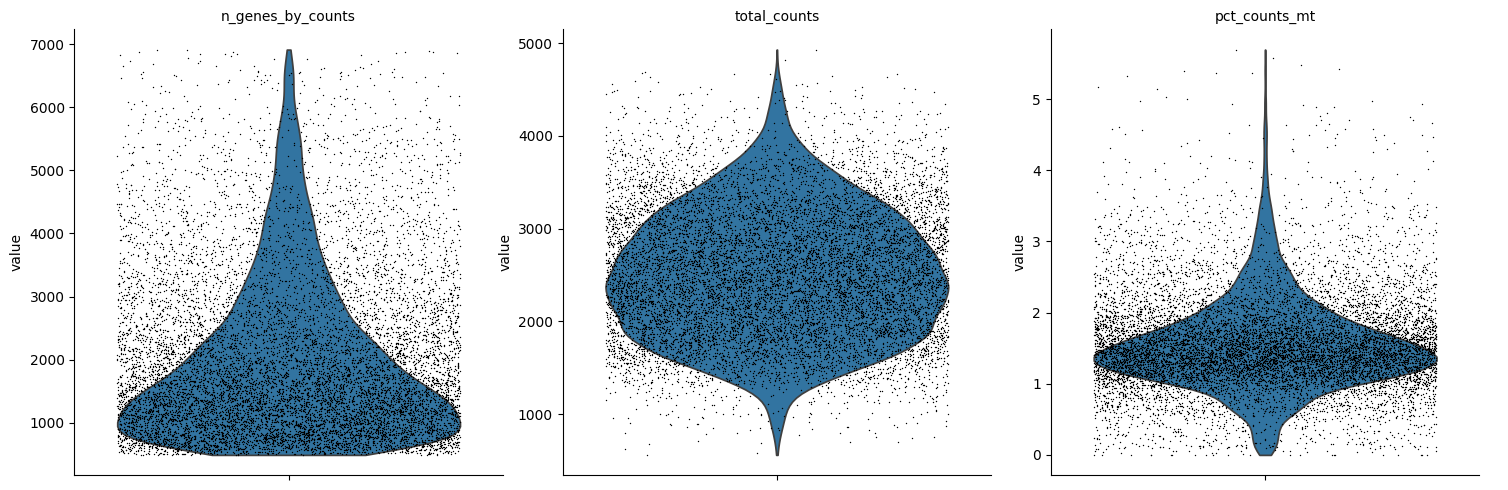

In [36]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [37]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [38]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

In [ ]:
sc.pp.scale(adata, max_value=10)

## Input data preprocess[ndarray(100, 12756, 2)*500]

In [33]:
file_path = '/home/nccpml/DATA2/hanbyeol/TEC/'
gene_list_df = pd.read_csv(file_path + 'CCIdb/CCIdb07.csv')
gene_list_df

,TumorGene,OtherGene
0,SEMA3F,PLXNA3
1,SEMA3F,PLXNA1
2,SEMA3F,NRP1
3,SEMA3F,NRP2
4,CX3CL1,CX3CR1
...,...,...
13009,VSIR,HLA-E
13010,VSIR,HLA-F
13011,NRXN3,NLGN4Y
13012,FGFR4,SDC2


In [26]:
cell_cnt = len(adata.obs.cell_type_subset.value_counts())-1
cell_cnt

In [32]:
# 전부 돌리기

for i in range(cell_cnt):
    # combi-cells_cX.txt 파일 로드
    file_name = f'combi-cells_c{i}.txt'
    combi_cells_df = pd.read_csv(f'{output_folder}/{file_name}', header=None)
    
    # 유전자 인덱스 추출 (순서 유지)
    tumor_gene_indices = [np.where(adata.var_names == gene)[0][0] for gene in gene_list_df['TumorGene'] if gene in adata.var_names]
    other_gene_indices = [np.where(adata.var_names == gene)[0][0] for gene in gene_list_df['OtherGene'] if gene in adata.var_names]

    print("Gene index extraction: ", i)
    # 결과를 저장할 리스트 초기화
    result_arrays = []    
    
    # 100개의 그룹으로 나누어 각 그룹에서 발현 데이터 생성
    for group_start in range(0, 50000, 100):
        tumor_cells = combi_cells_df.iloc[group_start:group_start+100, 0]
        other_cells = combi_cells_df.iloc[group_start:group_start+100, 1]

        # 발현 데이터 배열 생성
        expression_data_tumor = np.array([adata[adata.obs_names.isin([cell]), tumor_gene_indices].X.toarray().flatten() for cell in tumor_cells])
        expression_data_other = np.array([adata[adata.obs_names.isin([cell]), other_gene_indices].X.toarray().flatten() for cell in other_cells])

        # 두 채널 결합하여 결과에 추가
        combined_expression_data = np.stack((expression_data_tumor, expression_data_other), axis=-1)
        result_arrays.append(combined_expression_data.astype(np.float32))

    print("Data configuration complete: ", i)
        
    # 결과를 .npz 파일로 저장
    np.savez(f'{output_folder}/{file_name.replace(".txt", ".npz")}', *result_arrays)

    print(f"File {file_name} processed and saved as .npz")

Gene index extraction:  0
Data configuration complete:  0
File combi-cells_c0.txt processed and saved as .npz
Gene index extraction:  1
Data configuration complete:  1
File combi-cells_c1.txt processed and saved as .npz
Gene index extraction:  2
Data configuration complete:  2
File combi-cells_c2.txt processed and saved as .npz
Gene index extraction:  3
Data configuration complete:  3
File combi-cells_c3.txt processed and saved as .npz
Gene index extraction:  4
Data configuration complete:  4
File combi-cells_c4.txt processed and saved as .npz
Gene index extraction:  5
Data configuration complete:  5
File combi-cells_c5.txt processed and saved as .npz
Gene index extraction:  6
Data configuration complete:  6
File combi-cells_c6.txt processed and saved as .npz


In [33]:
print(f"Total number of arrays: {len(result_arrays)}")  # 1000개의 배열이 생성되었는지 확인
print(result_arrays[0].shape)  # 첫 번째 배열의 형태 확인

Total number of arrays: 500
(100, 12756, 2)


In [35]:
list = os.listdir(output_folder)
list.sort()
list

['combi-cells_c0.npz',
 'combi-cells_c0.txt',
 'combi-cells_c1.npz',
 'combi-cells_c1.txt',
 'combi-cells_c2.npz',
 'combi-cells_c2.txt',
 'combi-cells_c3.npz',
 'combi-cells_c3.txt',
 'combi-cells_c4.npz',
 'combi-cells_c4.txt',
 'combi-cells_c5.npz',
 'combi-cells_c5.txt',
 'combi-cells_c6.npz',
 'combi-cells_c6.txt']